**Main objective of the analysis that specifies whether your model will be focused on prediction or interpretation.**

Train regression model on the dataset to predict the number of passengers

**Brief description of the data set you chose and a summary of its attributes**

The dataset know as Monthly International Airline Passengers Dataset and it used mostly in Univariate Time Series Analysis.
It has a total of 144 rows and 2 columns

| S No. | Column | Description| Data Type | Category| Type
| --- | --- | --- | --- | --- | --- |
|1 | Month | Month and the year of the flight | Int | Discrete | Variable |
|2 | #Passengers | Number of Passengers for the corresponding month | Int | Discrete | Target |

**Plan for Data Exploration, Feature Engineering and Modelling**

The steps in solving the Regression Problem are as follows:
1. Packages to be installed
2. Load the libraries
3. Load the dataset
4. General information about the dataset
5. Exploratory Data Analysis (EDA)
6. Key Findings and Insights
7. Modeling
8. Recommendations

## Packages to be installed

1. darts
2. adtk

In [ ]:
!pip install dart
!pip install adtk

## Load the libraries

1. numpy
2. pandas
3. matplotlib
4. seaborn
5. darts
6. xgboost
7. adtk

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
sns.set_palette("tab10")
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA, VARIMA, AutoARIMA, RegressionEnsembleModel,  ExponentialSmoothing, Theta
from darts.models import FourTheta, Prophet, FFT, RandomForest, LightGBMModel, TFTModel, NaiveSeasonal, NaiveDrift
from darts.models import TransformerModel, NBEATSModel, BlockRNNModel, RNNModel, TCNModel
from  darts.utils.likelihood_models import GaussianLikelihood
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, remove_seasonality, remove_trend, plot_residuals_analysis
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from adtk.detector import InterQuartileRangeAD, PersistAD
from adtk.aggregator import OrAggregator
from adtk.data import validate_series
from adtk.visualization import plot
from darts.utils.utils import ModelMode, SeasonalityMode
import statsmodels as sm
import statsmodels.tsa.stattools as ts
import shutup
shutup.please()

## Load the dataset

location of dataset

In [3]:
dataset = 'AirPassengers.csv'

reading the dataset into dataframe

In [4]:
df = pd.read_csv(dataset)

## General information about the dataset

sampling the data

In [5]:
print(df.head())

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121


number of rows and coulmns in dataset

In [6]:
print(df.shape)

(144, 2)


dataset information

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None


**Actions taken for data cleaning and feature engineering**

correcting date format

In [8]:
df['Month'] = pd.to_datetime(df['Month'])

Features Encoding

In [9]:
df['Lag'] = df['#Passengers'].diff(12)
df.dropna(inplace=True)

## Exploratory Data Analysis (EDA)

Summary Statistics for Time Series

In [10]:
print(df.describe(include='all'))

                      Month  #Passengers         Lag
count                   132   132.000000  132.000000
unique                  132          NaN         NaN
top     1950-01-01 00:00:00          NaN         NaN
freq                      1          NaN         NaN
first   1950-01-01 00:00:00          NaN         NaN
last    1960-12-01 00:00:00          NaN         NaN
mean                    NaN   294.265152   31.772727
std                     NaN   115.480798   17.654699
min                     NaN   114.000000   -8.000000
25%                     NaN   196.000000   21.000000
50%                     NaN   275.500000   30.000000
75%                     NaN   363.250000   45.250000
max                     NaN   622.000000   74.000000


Visual Exploration of Time Series

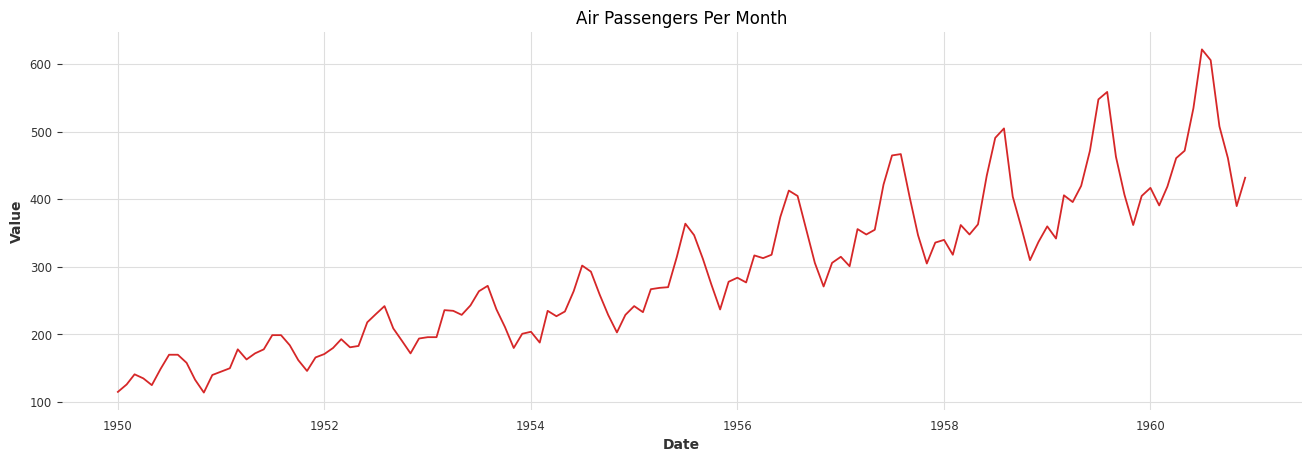

In [11]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df['Month'], y=df['#Passengers'], title='Air Passengers Per Month')

Boxplot of Year-wise (Trend) and Month-wise (Seasonal) Distribution

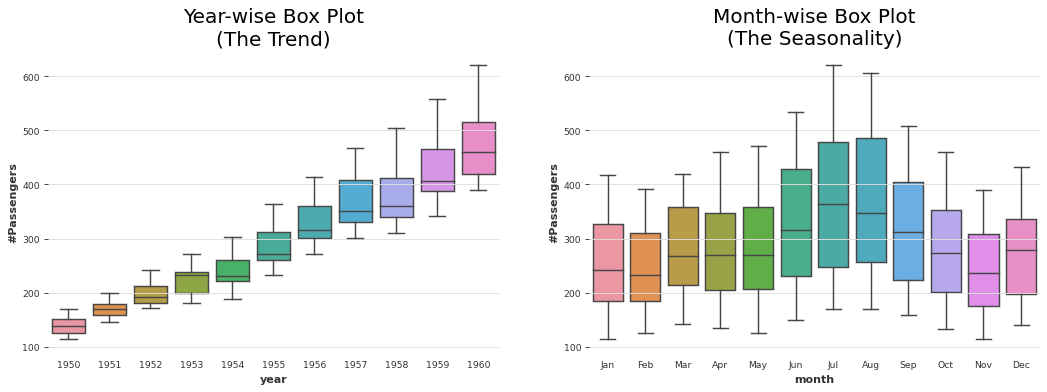

In [12]:
df['year'] = [d.year for d in df.Month]
df['month'] = [d.strftime('%b') for d in df.Month]
years = df['year'].unique()
fig, axes = plt.subplots(1, 2, figsize=(16,5), dpi= 80)
sns.boxplot(x='year', y='#Passengers', data=df, ax=axes[0])
sns.boxplot(x='month', y='#Passengers', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

Detecting Anamolies in the Time Series

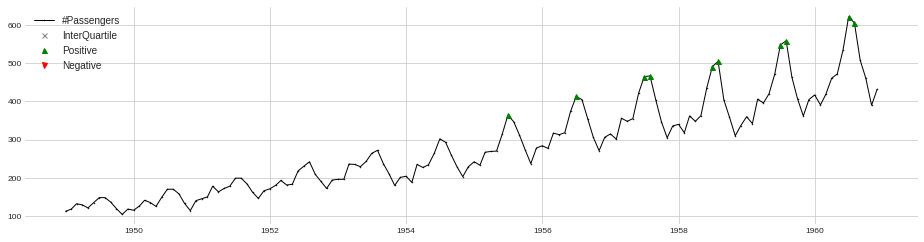

In [13]:
s = pd.read_csv('AirPassengers.csv', index_col="Month", parse_dates=True, squeeze=True)
s = validate_series(s)
quantile_ad = InterQuartileRangeAD(c=1.5)
negative_persist_ad = PersistAD(c=1.5, side='negative',window = 12)
positive_persist_ad = PersistAD(c=1.5, side='positive',window = 12)
quantile_anomalies = quantile_ad.fit_detect(s)
negative_anomalies = negative_persist_ad.fit_detect(s)
positive_anomalies = positive_persist_ad .fit_detect(s)
anomalies = pd.concat([quantile_anomalies,negative_anomalies,positive_anomalies],axis=1)
anomalies.columns=["InterQuartile", "Positive","Negative"]
anomalies = OrAggregator().aggregate(anomalies)
plot(s, anomaly={'InterQuartile':quantile_anomalies, "Positive": positive_anomalies, "Negative": negative_anomalies},anomaly_marker={'InterQuartile':'x', "Positive": "^", "Negative": "v"}, ts_linewidth=1, ts_markersize=1, anomaly_markersize=5, anomaly_color={'InterQuartile':'gray', "Positive": "green", "Negative": "red"}, anomaly_tag="marker");

Test for Seasonnality and Frequency Period

In [14]:
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')
check_seasonality(series)

(True, 12)

Time Series Decomposition

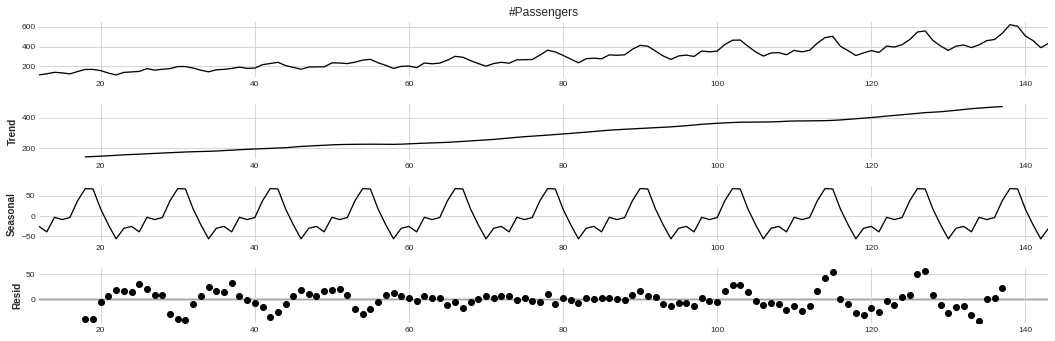

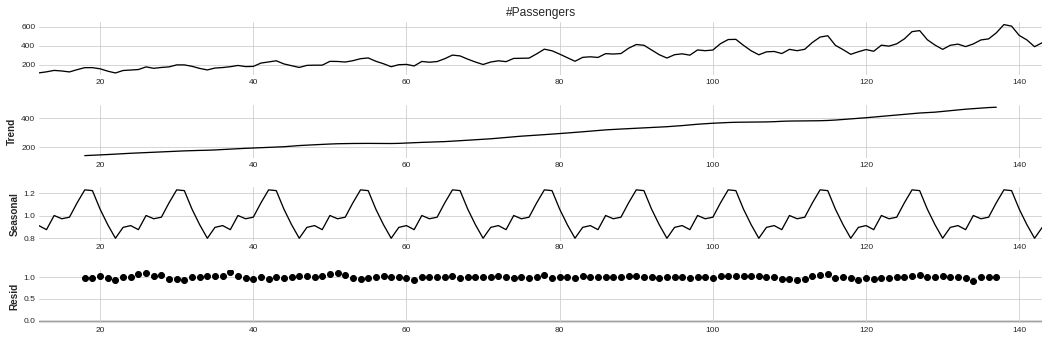

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
components_add = seasonal_decompose(df['#Passengers'],model='additive',period=12)
components_mul = seasonal_decompose(df['#Passengers'],model='multiplicative',period=12)

figure_add = components_add.plot()
figure_mul = components_mul.plot()
figure_add.set_size_inches(16, 5)
figure_mul.set_size_inches(16, 5)

Based on the comparasion above, this time seris is multiplicative as there is no pattern for residuals

Residuals_Analysis

In [16]:
residuals = remove_trend(remove_seasonality(series))

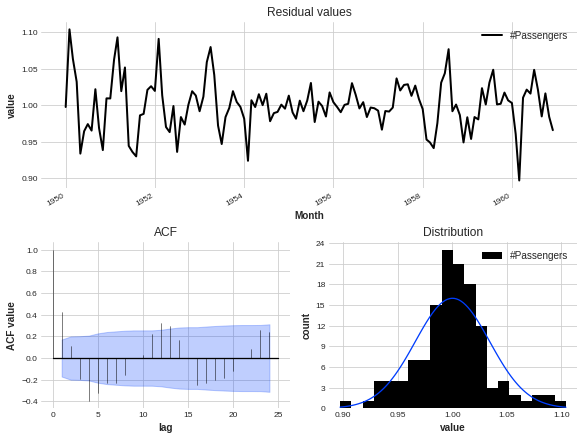

In [17]:
plot_residuals_analysis(residuals)

Test for stationarity with Augmented Dickey Fuller Test (ADF Test)

In [18]:
def dftest_stationarity(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(16,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show()

Test Statistic            0.688129
p-value                   0.989598
Lags Used                13.000000
Observations Used       118.000000
Critical Value (1%)      -3.487022
Critical Value (5%)      -2.886363
Critical Value (10%)     -2.580009
dtype: float64


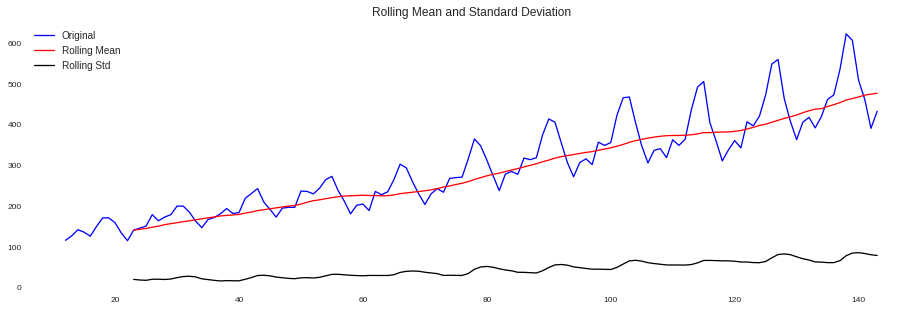

In [19]:
dftest_stationarity(df['#Passengers'])

testing for stationary after differencing the time-seris

Test Statistic           -3.383021
p-value                   0.011551
Lags Used                 1.000000
Observations Used       130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


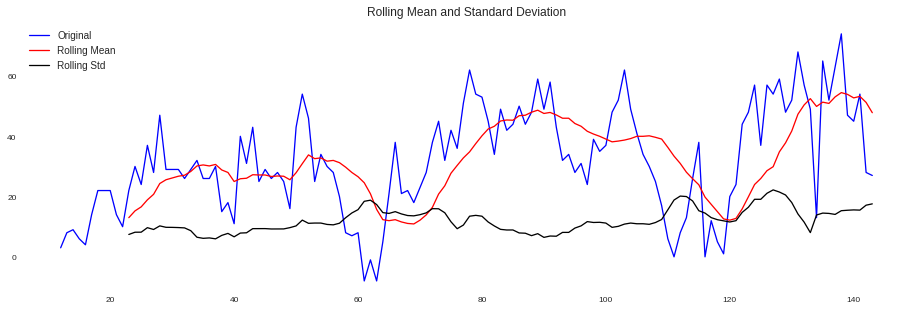

In [20]:
dftest_stationarity(df['Lag'])

The time series is stationary and ready for modeling

## Key Findings and Insights

* Based on trend: the number of passengers is increasing every year
* Based on seasonality: summer months are the ones with the most travellers

## Modeling

**Modelling  Task Details**

| S No. | Description| Category| Type |
| --- | --- | --- | --- | 
|1 | Data being used| Structured | Numerical |
|2 | Machine learning problem | Regression |  Univariate |
|3 | Relevant ML and DL models | Mutiple Ml and DL Model | Times-Series Related |
|4 | Technical metrics | MAPE | Percentage (the lower the better) |
|5 | Hyperparameter optimization techniques | Grid search | Specified Dictionary |
|6 | Computation method | On-premise | CPU | 
|7 | Additional Features | Historical Forecast | Check for Perfomance | 

we will be training Multiple algorithms from the Darts library and the comparing them according to accuracy on the testing dataset
Expected runtime: 1 Hours

In [21]:
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')
training, validation = series.split_after(0.7)
year_series = datetime_attribute_timeseries(pd.date_range(start=series.start_time(), freq=series.freq_str, periods=1000),
                                             attribute='year', one_hot=False)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(year_series, attribute='month', one_hot=True)
covariates = year_series.stack(month_series)

In [22]:
global_models = [
    TransformerModel(input_chunk_length=30,output_chunk_length=20),
    NBEATSModel(input_chunk_length=30,output_chunk_length=20),
    BlockRNNModel(model='LSTM',input_chunk_length=30,output_chunk_length=20),
    BlockRNNModel(model='GRU',input_chunk_length=30,output_chunk_length=20),
    BlockRNNModel(model='RNN',input_chunk_length=30,output_chunk_length=20),
    RNNModel(model='LSTM',input_chunk_length=30,output_chunk_length=20),
    RNNModel(model='GRU',input_chunk_length=30,output_chunk_length=20),
    RNNModel(model='RNN',input_chunk_length=30,output_chunk_length=20),
    RandomForest(lags=12),
    LightGBMModel(lags=12),
]

non_global_models = [
    NaiveSeasonal(K=12),
    NaiveDrift(),
    ARIMA(),
    AutoARIMA(),
    ExponentialSmoothing(),
    Theta(),
    FourTheta(),
    Prophet(),
    FFT(trend='poly'),
]

xgb_model = xgb.XGBRegressor()
ensemble_model = RegressionEnsembleModel(forecasting_models=non_global_models,
                                         regression_train_n_points=len(training)//10,
                                         regression_model=xgb_model)

models=[]
scores=[]

In [23]:
def eval_model(model, series=series,tra_series=training, val_series=validation):
    model.fit(training)
    pred_series = model.predict(len(validation))
    models.append(model)
    scores.append(mape(pred_series, validation))

In [24]:
for model in non_global_models:
    eval_model(model)

for model in global_models:
    eval_model(model)

eval_model(ensemble_model)

In [25]:
model_scores = pd.DataFrame({'Model':models,'MAPE_Score':scores})
model_scores.sort_values('MAPE_Score',ascending=True,inplace=True)
model_scores

,Model,MAPE_Score
4,Exponential smoothing,6.027261
5,Theta(2),7.011562
6,"4Theta(theta:2, curve:TrendMode.LINEAR, model:...",7.023861
2,"ARIMA(12, 1, 0)",7.612379
10,<darts.models.forecasting.nbeats.NBEATSModel o...,9.683169
7,Prophet,9.935419
19,<darts.models.forecasting.regression_ensemble_...,11.135645
17,"RandomForest(lags=[-12, -11, -10, -9, -8, -7, ...",12.827509
3,Auto-ARIMA,13.059855
18,"LGBModel(lags=[-12, -11, -10, -9, -8, -7, -6, ...",18.763894


We selected the best model based on the lowest score as the model for the modeling task

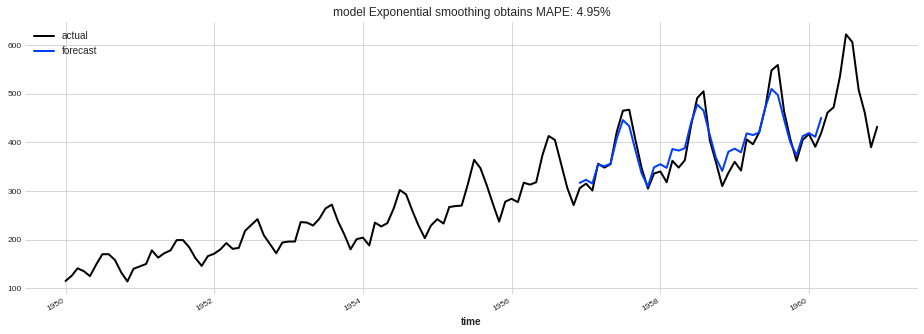

In [26]:
model = models[4]
pred_series =model.predict(len(validation))
plt.figure(figsize=(16,5))
series.plot(label='actual')
pred_series.plot(label='forecast',low_quantile=0.05, high_quantile=0.95)
plt.title('model {} obtains MAPE: {:.2f}%'.format(model,mape(pred_series, validation)))
plt.legend();

We need to test if the prposed model really captured the pattern in the data, so we ask the the model to look at more historical data and start building the prediction from earlier point

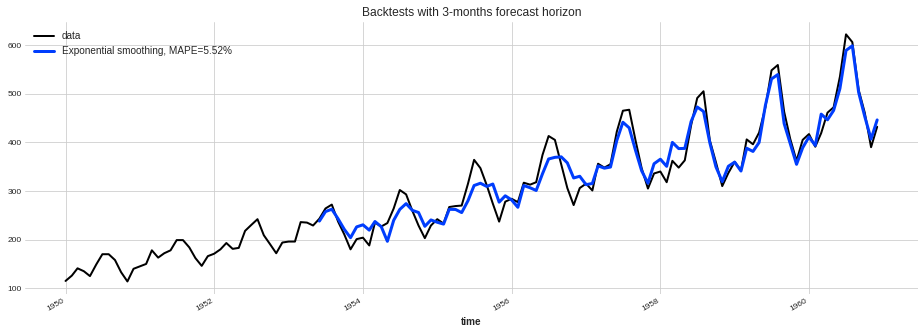

In [27]:
backtest = model.historical_forecasts(series=series,start=0.3,forecast_horizon=3)
error = mape(backtest, series)
plt.figure(figsize=(16,5))
series.plot(label='data')
backtest.plot(lw=3, label='{}, MAPE={:.2f}%'.format(model, error))
plt.title('Backtests with 3-months forecast horizon')
plt.legend();

we can see the model really successed on understanding the time series

## Recommendation

Selected model can be grid searched with parameters in order to increase its accuracy

In [28]:
parameters= {
'trend':[ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE],
'damped':[True,False],
'seasonal':[SeasonalityMode.ADDITIVE, SeasonalityMode.MULTIPLICATIVE],
'seasonal_periods':[12],
}

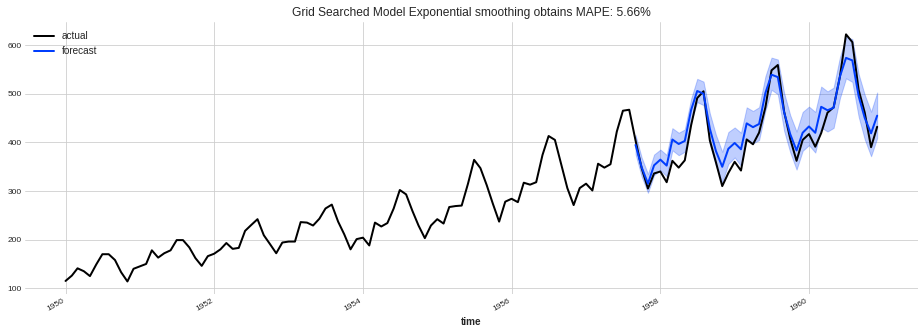

In [29]:
model.gridsearch(parameters=parameters,series=training,start=0.3,metric=mape,forecast_horizon=3)
model.fit(training)
pred_series =model.predict(len(validation),num_samples=1000)
plt.figure(figsize=(16,5))
series.plot(label='actual')
pred_series.plot(label='forecast',low_quantile=0.05, high_quantile=0.95)
plt.title('Grid Searched Model {} obtains MAPE: {:.2f}%'.format(model,mape(pred_series, validation)))
plt.legend();